In [1]:
import numpy as np
import pandas as pd

In [4]:
data = np.load("Data/sample_data.npz")
SR_OS = data['SR_OS']
LR_OS = data['LR_OS']
SR_poro = data['SR_poro']
LR_poro = data['LR_poro']
SR_BPR = data['SR_BPR']
LR_BPR = data['LR_BPR']

In [39]:
def giveMeDensityMyLove(pressure):
    pvdo_table = np.array([[300,1.05],[800,1.02],[8000,1.01]])
    pl = None
    ph = None
    for i in range(pvdo_table.shape[0]):
        if pvdo_table[i,0]>=pressure:
            pl = i-1
            ph = i
            break
    if pl is None:
        # Data beyond table. Cannot Extrapolate
        return pvdo_table[pvdo_table.shape[0]-1,1]
    elif pl < 0:
        # Data beyond table. Cannot Extrapolate
        return pvdo_table[0,1]
    else:
        # Linearly interpolate bo between two table entries
        dbo_dp = (pvdo_table[ph,1]-pvdo_table[pl,1])/(pvdo_table[ph,0]-pvdo_table[pl,0])
        Dp = pressure-pvdo_table[pl,0]
        return pvdo_table[pl,1]+(dbo_dp*Dp)
print(giveMeDensityMyLove(7500))

1.0106944444444446


In [42]:
vol_cell_SR = 10*20*2               # Volume of a Cell in Super Res Model
vol_cell_LR = 20*40*2               # Volume of a Cell in Low Res Model                 
rho_So = 53                         # Density of Oil in Surface

rho_SR*SR_poro*vol_cell_SR*SR_OS

Vol_FS_SR = SR_poro*vol_cell_SR     # Porosity = Volume of Free space / Volume of Cell
Vol_Oil_SR = SR_OS*Vol_FS_SR        # Oil Saturation = Volume of Oil / Volume of free space
bo_SR = np.zeros(Vol_Oil_SR.shape)
for i in range(bo_SR.shape[0]):
    for j in range(bo_SR.shape[1]):
        for k in range(bo_SR.shape[2]):
            bo_SR[i,j,k] = giveMeDensityMyLove(SR_BPR[i,j,k]) # Getting bo for each cell's pressure
rho_SR = bo_SR*rho_So               # bo = density of Oil in the cell / density of Oil in Surface
mass_SR = rho_SR*Vol_Oil_SR

Vol_FS_LR = LR_poro*vol_cell_LR
Vol_Oil_LR = LR_OS*Vol_FS_LR
bo_LR = np.zeros(Vol_Oil_LR.shape)
for i in range(bo_LR.shape[0]):
    for j in range(bo_LR.shape[1]):
        for k in range(bo_LR.shape[2]):
            bo_LR[i,j,k] = giveMeDensityMyLove(LR_BPR[i,j,k])
rho_LR = bo_LR*rho_So
mass_LR = rho_LR*Vol_Oil_LR

print(np.sum(mass_SR),np.sum(mass_LR))
print("Percentage Error in Mass Balance=",(np.sum(mass_SR)-np.sum(mass_LR))*100/np.sum(mass_LR),"<3")

27198682.18005914 26584075.005984776
Percentage Error in Mass Balance= 2.311937405894313 <3


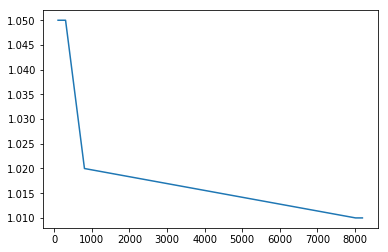

In [41]:
import matplotlib.pyplot as plt
ps=np.arange(100,8200)
bos=[]
for p in ps:
    bos.append(giveMeDensityMyLove(p))
plt.plot(ps, bos, '-')